In [19]:
# THIS NOTEBOOK WAS RUNNING IN GOOGLE COLAB


!kaggle datasets download -d khlaifiabilel/military-aircraft-recognition-dataset

100% 1.12G/1.13G [00:12<00:00, 124MB/s] 
100% 1.13G/1.13G [00:12<00:00, 95.1MB/s]


In [53]:
!unzip military-aircraft-recognition-dataset.zip -d "data"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/Annotations/Oriented Bounding Boxes/3416.xml  
  inflating: data/Annotations/Oriented Bounding Boxes/3417.xml  
  inflating: data/Annotations/Oriented Bounding Boxes/3418.xml  
  inflating: data/Annotations/Oriented Bounding Boxes/3419.xml  
  inflating: data/Annotations/Oriented Bounding Boxes/342.xml  
  inflating: data/Annotations/Oriented Bounding Boxes/3420.xml  
  inflating: data/Annotations/Oriented Bounding Boxes/3421.xml  
  inflating: data/Annotations/Oriented Bounding Boxes/3422.xml  
  inflating: data/Annotations/Oriented Bounding Boxes/3423.xml  
  inflating: data/Annotations/Oriented Bounding Boxes/3424.xml  
  inflating: data/Annotations/Oriented Bounding Boxes/3425.xml  
  inflating: data/Annotations/Oriented Bounding Boxes/3426.xml  
  inflating: data/Annotations/Oriented Bounding Boxes/3427.xml  
  inflating: data/Annotations/Oriented Bounding Boxes/3428.xml  
  inflating: data/Annot

In [21]:
# Paths
ROOT_DIR = "data/"
IMAGE_DIR = ROOT_DIR + "JPEGImages/"
HORIZONTAL_BB = ROOT_DIR + "Annotations/Horizontal Bounding Boxes/"
ORIENTED_BB = ROOT_DIR + "Annotations/Oriented Bounding Boxes/"

TRAIN_SET_TXT = ROOT_DIR + "ImageSets/Main/train.txt"
TEST_SET_TXT = ROOT_DIR + "ImageSets/Main/test.txt"

In [22]:
# Imports
import random
import os
import xml.etree.ElementTree as ET
import shutil
import yaml

import cv2
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [23]:
%matplotlib inline

In [24]:
# Helping functions
# Displaying images

def get_image(image_path: str):
    img = cv2.imread(image_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def get_image_shape(image_path: str):
    img = cv2.imread(image_path)
    return img.shape

def get_image_from_id(obj_id: str):
    image_path = IMAGE_DIR + obj_id + ".jpg"
    return get_image(image_path)

def display_image(image_name: str):
    image_path = IMAGE_DIR + image_name
    plt.imshow(get_image(image_path))

def get_random_img_names():
    return random.sample(os.listdir(IMAGE_DIR), 16)

In [25]:
# Reading xml files
# XML reader
def parse_xml(xml_file_path: str):
    # Parses xml file, returns dict
    tree = ET.parse(xml_file_path)

    filename = tree.find('filename').text
    img_size = {
        'width': int(tree.find('size').find('width').text),
        'height': int(tree.find('size').find('height').text),
        'depth': int(tree.find('size').find('depth').text)
    }
    segmented = int(tree.find('segmented').text)
    bboxes = []
    for obj in tree.findall('object'):
        bndbox = obj.find('bndbox')
        bboxes.append({
            'name': obj.find('name').text,
            'xmin': int(bndbox.find('xmin').text),
            'ymin': int(bndbox.find('ymin').text),
            'xmax': int(bndbox.find('xmax').text),
            'ymax': int(bndbox.find('ymax').text)
        })
    database = tree.find('source').find('database').text

    return {
        'filename': filename,
        'img_size': img_size,
        'segmented': segmented,
        'bboxes': bboxes,
        'database': database
    }

def get_xml_file_path(filename, option='HORIZONTAL'):
    if option == 'HORIZONTAL':
        return HORIZONTAL_BB + filename
    elif option == 'ORIENTED':
        return ORIENTED_BB + filename

In [26]:
classes = ['A19', 'A1', 'A20', 'A16', 'A5', 'A13', 'A15', 'A3', 'A17', 'A11',
       'A14', 'A8', 'A2', 'A10', 'A9', 'A4', 'A18', 'A7', 'A12', 'A6']

classes_map = {item: index for index, item in enumerate(classes)}

In [27]:
classes_map

{'A19': 0,
 'A1': 1,
 'A20': 2,
 'A16': 3,
 'A5': 4,
 'A13': 5,
 'A15': 6,
 'A3': 7,
 'A17': 8,
 'A11': 9,
 'A14': 10,
 'A8': 11,
 'A2': 12,
 'A10': 13,
 'A9': 14,
 'A4': 15,
 'A18': 16,
 'A7': 17,
 'A12': 18,
 'A6': 19}

In [28]:
def get_train_set_ids():
    with open(TRAIN_SET_TXT, 'r') as file:
        ids = file.read().splitlines()
    return ids

def get_test_set_ids():
    with open(TEST_SET_TXT, 'r') as file:
        ids = file.read().splitlines()
    return ids

train_set_ids = get_train_set_ids()
test_set_ids = get_test_set_ids()
print(f'Size of train set is: {len(train_set_ids)}')
print(f'Size of test set is: {len(test_set_ids)}')
print(f'Total images: {len(train_set_ids) + len(test_set_ids)}')

Size of train set is: 1331
Size of test set is: 2511
Total images: 3842


In [54]:
# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict, obj_id, save_folder):
    print_buffer = []

    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = classes_map[b["name"]]
        except KeyError:
            print("Invalid Class. Must be one from ", classes_map.keys())

        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])

        # Normalise the co-ordinates by the dimensions of the image
        image_h, image_w, image_c = get_image_shape(IMAGE_DIR + obj_id + ".jpg")
        b_center_x /= image_w
        b_center_y /= image_h
        b_width    /= image_w
        b_height   /= image_h

        #Write the bbox details to the file
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    # Name of the file which we have to save
    save_file_name = os.path.join(save_folder, obj_id + ".txt")

    # Save the annotation to disk
    # print("\n".join(print_buffer), file= open(save_file_name, "w"))
    with open(save_file_name, 'w') as fl:
      fl.write("\n".join(print_buffer))

In [55]:
!mkdir "data for yolo"
!mkdir "data for yolo/labels"
!mkdir "data for yolo/images"

mkdir: cannot create directory ‘data for yolo’: File exists
mkdir: cannot create directory ‘data for yolo/labels’: File exists
mkdir: cannot create directory ‘data for yolo/images’: File exists


In [56]:
!mkdir "data for yolo/labels/train"
!mkdir "data for yolo/labels/test"
!mkdir "data for yolo/images/train"
!mkdir "data for yolo/images/test"

mkdir: cannot create directory ‘data for yolo/labels/train’: File exists
mkdir: cannot create directory ‘data for yolo/labels/test’: File exists
mkdir: cannot create directory ‘data for yolo/images/train’: File exists
mkdir: cannot create directory ‘data for yolo/images/test’: File exists


In [57]:
for obj_id in train_set_ids:
  info_dict = parse_xml(HORIZONTAL_BB + str(obj_id) + ".xml")
  convert_to_yolov5(info_dict, str(obj_id), "data for yolo/labels/train/")

for obj_id in test_set_ids:
  info_dict = parse_xml(HORIZONTAL_BB + str(obj_id) + ".xml")
  convert_to_yolov5(info_dict, str(obj_id), "data for yolo/labels/test/")

In [36]:
#Utility function to move images
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

train_img_files = [IMAGE_DIR + str(obj_id) + ".jpg" for obj_id in train_set_ids]
test_img_files = [IMAGE_DIR + str(obj_id) + ".jpg" for obj_id in test_set_ids]

# Move the splits into their folders
move_files_to_folder(train_img_files, 'data for yolo/images/train')
move_files_to_folder(test_img_files, 'data for yolo/images/test')

In [37]:
random.seed(0)

class_id_to_name_mapping = dict(zip(classes_map.values(), classes_map.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.shape[0], image.shape[1]

    # plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann

        image = cv2.rectangle(image, (int(x0),int(y0)), (int(x1),int(y1)), (255,0,0), 2)

        cv2.putText(image, class_id_to_name_mapping[(int(obj_cls))],
         (int(x0), int(y0) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,20,20), 3)

    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file
annotation_file = random.choice(os.listdir("data for yolo/"))
an_filepath = "annotations/" + annotation_file
with open(an_filepath, "r") as file:
    annotation_list = file.read().split("\n")
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("txt", "jpg")
assert os.path.exists(IMAGE_DIR + image_file)

#Load the image
image = get_image(IMAGE_DIR + image_file)
#Plot the Bounding Box
plot_bounding_box(image, annotation_list)


FileNotFoundError: ignored

In [38]:
d = {
    'path':'data for yolo/',
    'images':{
    'train': 'images/train',
    'test': 'images/test',},
    'labels': {
        'train': 'labels/train',
        'test': 'labels/test'
    },
    'nc': 20,
    'names': class_id_to_name_mapping
    }

with open('dataset.yml', 'w') as yaml_file:
    yaml.dump(d, yaml_file, default_flow_style=False)

In [ ]:
!pip install ultralytics

In [41]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', autoshape=False, pretrained=False)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-10-13 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]         

In [43]:
!git clone https://github.com/ultralytics/yolov5  # clone
!pip install -r yolov5/requirements.txt  # install


Cloning into 'yolov5'...
remote: Enumerating objects: 16003, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 16003 (delta 21), reused 20 (delta 13), pack-reused 15967
Receiving objects: 100% (16003/16003), 14.66 MiB | 29.32 MiB/s, done.
Resolving deltas: 100% (10983/10983), done.


In [60]:
# Train YOLOv5s on COCO128 for 3 epochs
!python yolov5/train.py --img 800 --batch 32 --epochs 50 --data dataset.yml

train: weights=yolov5/yolov5s.pt, cfg=, data=dataset.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=800, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, h

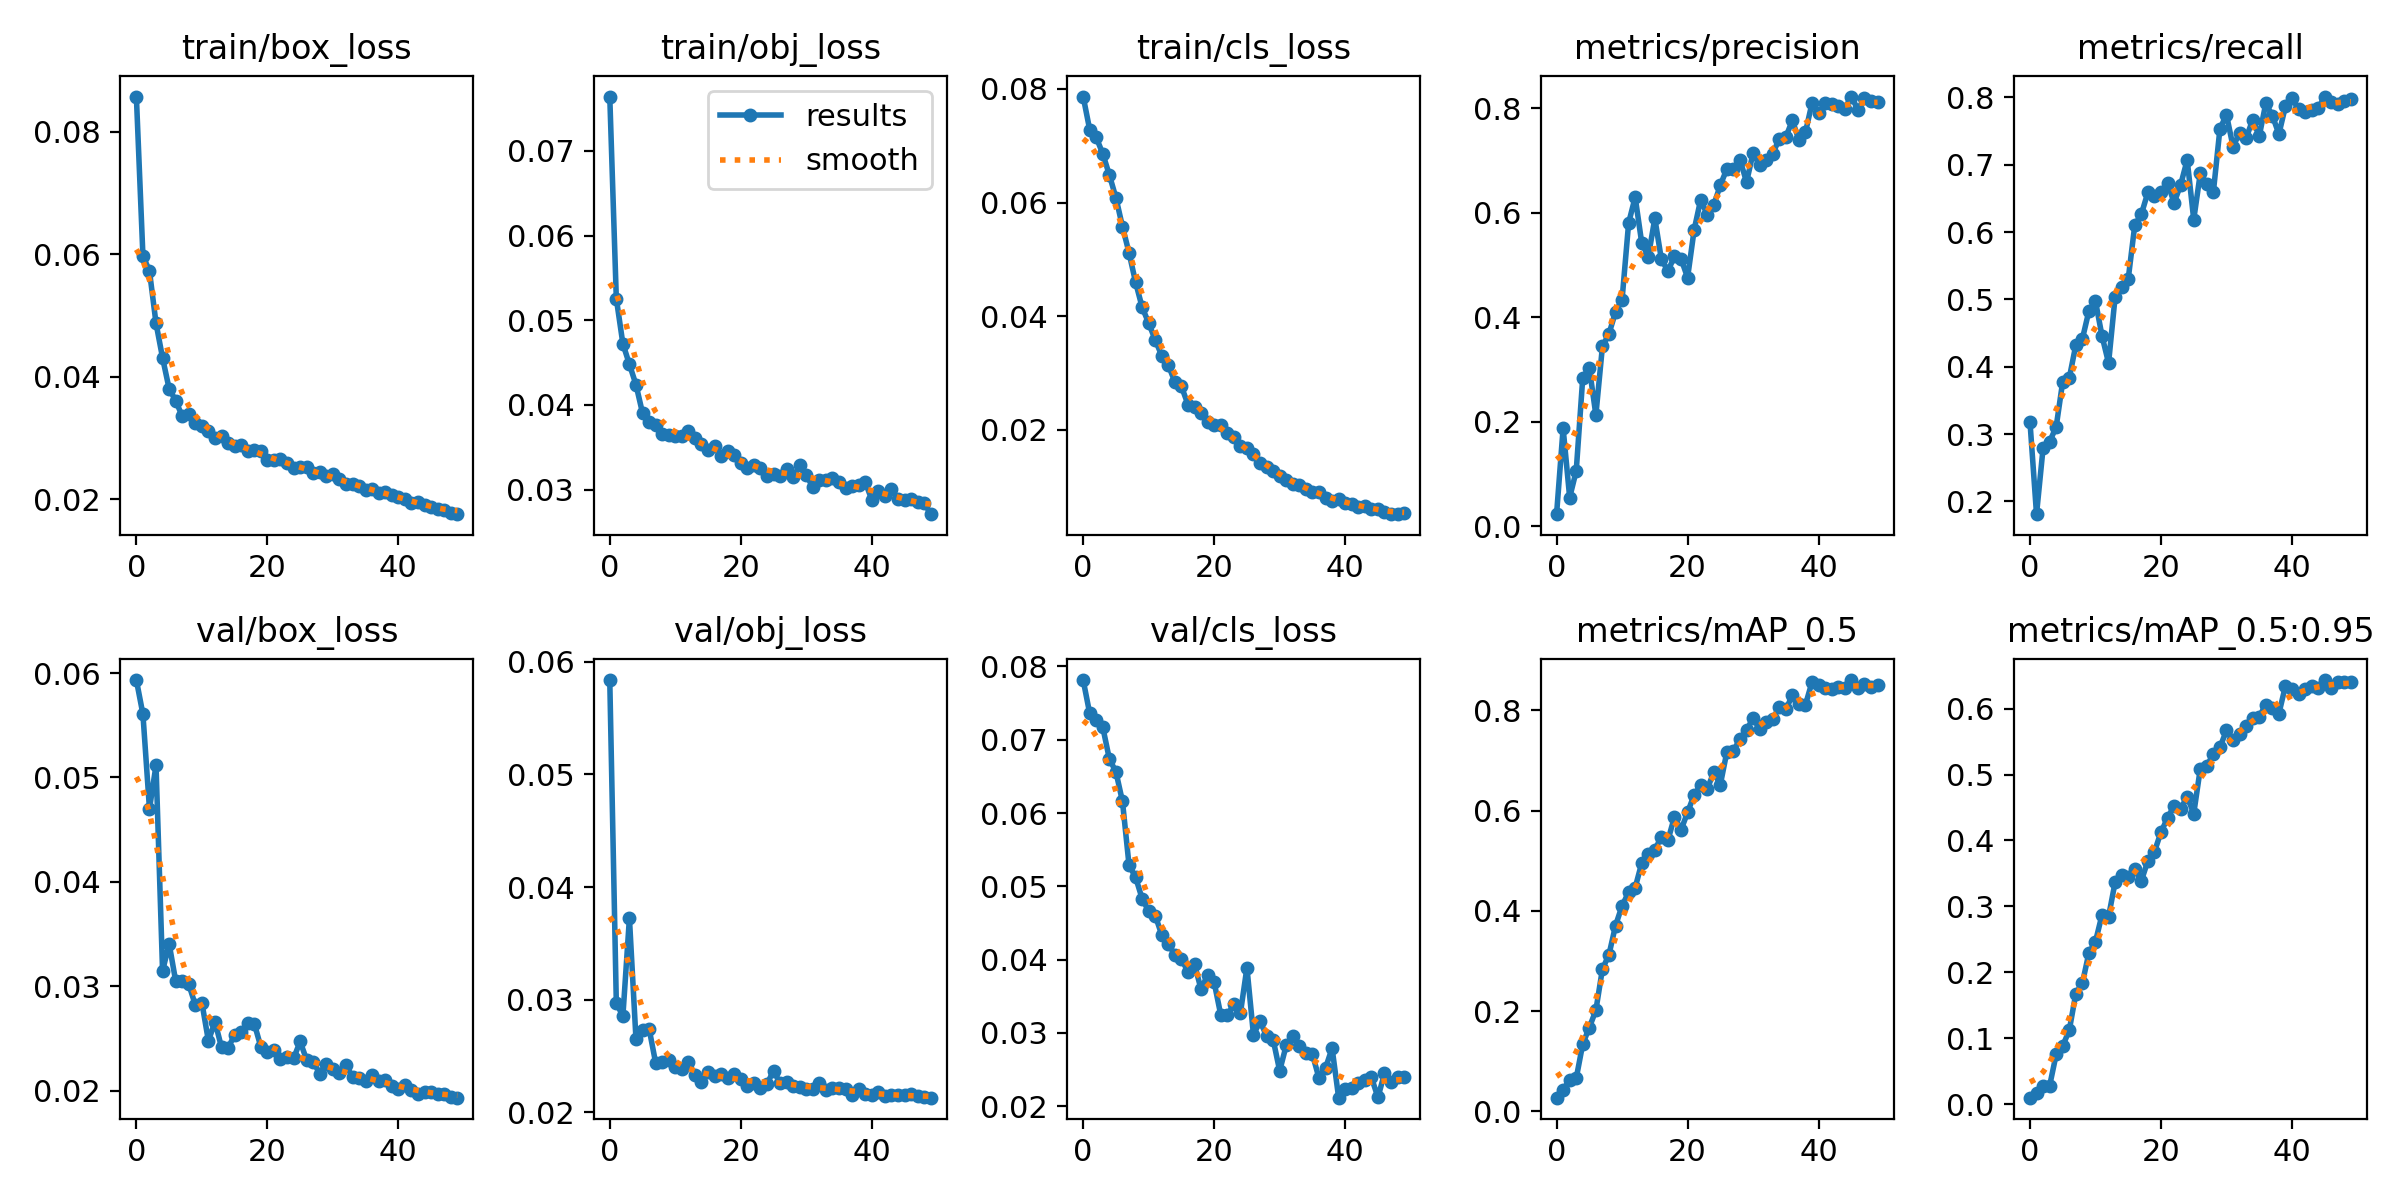

In [69]:
from IPython.display import Image, clear_output
from yolov5.utils.plots import plot_results
Image('yolov5/runs/train/exp7/results.png')

In [ ]:
# Train YOLOv5s on COCO128 for 3 epochs
!python yolov5/train.py --img 640 --batch 32 --epochs 50 --data dataset.yml

train: weights=yolov5/yolov5s.pt, cfg=, data=dataset.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, h